# Time Series Forecast with Keras

## Contents

1. [Imports](#imports)
1. [Load Dataset](#load-dataset)
1. [Dataset Preparation](#dataset-preparation)
1. [Definition of Deep Learning Architectures](#definition-deep-learning-architectures)
1. [Building Deep Learning Models](#building-deep-learning-models)
1. [Results](#results)

## Imports
<a id="imports"></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Flatten, TimeDistributed, RepeatVector, TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.callbacks import ModelCheckpoint

## Load Dataset
<a id="load-dataset"></a>

The data were obtained from <a href="https://finance.yahoo.com/quote/FB/history/">Finance Yahoo</a> (Facebook), in weekly periods, between 11/2015 and 11/2020.

In [2]:
dataset = pd.read_csv('dataset/FB.csv', parse_dates=['Date']).set_index('Date')
print('Shape:',dataset.shape)
dataset.head()

Shape: (263, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-11-16,106.839996,107.870003,106.620003,107.320000,107.320000,22129600
2015-11-23,107.190002,107.470001,104.389999,105.449997,105.449997,64538400
2015-11-30,105.839996,107.919998,103.349998,106.180000,106.180000,112055400
2015-12-07,106.480003,106.910004,101.910004,102.120003,102.120003,103276000
2015-12-14,102.290001,107.750000,101.459999,104.040001,104.040001,126762800


## Dataset Preparation
<a id="dataset-preparation"></a>

For this study we are interested only in the Open field.

Text(0, 0.5, 'Open')

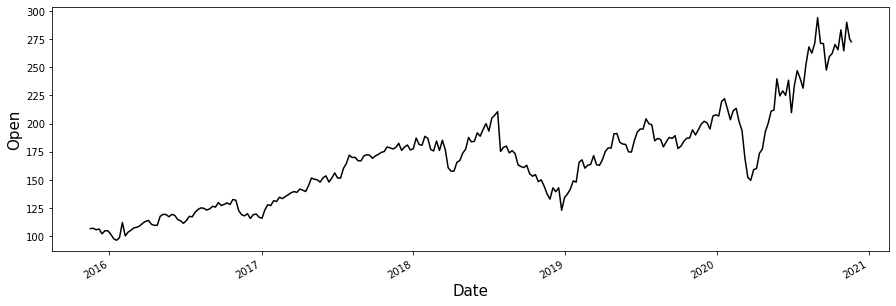

In [3]:
dataset = dataset[['Open']]

plt.figure(figsize=(15, 5))
dataset['Open'].plot(color='black')
plt.xlabel('Date', size=15)
plt.ylabel('Open', size=15)

Checking for nulls

In [4]:
print(dataset.isnull().sum().sum())

0


Sorting database

In [5]:
dataset.sort_index(inplace=True)

Shifting database in order to create the past observations as features.

In [6]:
target_column = 'Open'

def shift_dataset(df, periods, target_column):
    
    for i in range(periods):
        name_new_column = target_column + '_shift_' + str(i+1)
        df.loc[:, name_new_column] = df[target_column].shift(i+1)
        
    return df.copy()

periods_to_shift = 4

dataset_ml = shift_dataset(dataset, periods_to_shift, target_column)
dataset_ml.dropna(inplace=True)

dataset_ml.head()

,Open,Open_shift_1,Open_shift_2,Open_shift_3,Open_shift_4
Date,,,,,
2015-12-14,102.290001,106.480003,105.839996,107.190002,106.839996
2015-12-21,104.910004,102.290001,106.480003,105.839996,107.190002
2015-12-28,105.019997,104.910004,102.290001,106.480003,105.839996
2016-01-04,101.949997,105.019997,104.910004,102.290001,106.480003
2016-01-11,97.910004,101.949997,105.019997,104.910004,102.290001


Creation of train and test datasets

In [7]:
train_proportion = 0.9
train_size = int(dataset_ml.shape[0] * train_proportion)

train = dataset_ml.iloc[:train_size, :].copy()
test = dataset_ml.iloc[train_size:, :].copy()

scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

scaled_train = pd.DataFrame(data=scaled_train, columns=train.columns, index=train.index)
scaled_test = pd.DataFrame(data=scaled_test, columns=test.columns, index=test.index)

X_train = scaled_train.drop(target_column, axis=1).copy()
y_train = scaled_train[[target_column]].copy()

X_test = scaled_test.drop(target_column, axis=1).copy()
y_test = scaled_test[[target_column]].copy()

## Definition of Deep Learning Architectures
<a id="definition-deep-learning-architectures"></a>

In [8]:
def MLP_architecture(X, y, neurons, dropout, activation, optimizer, loss,
                     epochs, batch_size, validation_split, verbose):
    
    model = Sequential()
    model.add(Dense(neurons, activation=activation, input_dim=X.shape[1]))
    model.add(Dropout(dropout))
    model.add(Dense(int(neurons/2), activation=activation))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer=optimizer, loss=loss)
    
    checkpoint_filepath = 'saved_best_models/mlp/checkpoint_mlp'
    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                                save_weights_only=True,
                                                monitor='val_loss',
                                                mode='min',
                                                save_best_only=True)
    model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
              verbose=verbose, shuffle=False, callbacks=[model_checkpoint_callback])
    # The model weights (that are considered the best) are loaded into the model.
    model.load_weights(checkpoint_filepath)
    
    return model

In [9]:
def LSTM_architecture(X, y, neurons, dropout, activation, optimizer, loss,
                      epochs, batch_size, validation_split, verbose):


    # reshape from [samples, features] into [samples, timesteps, features]    
    X = X.reshape(X.shape[0], 1, X.shape[1])
        
    model = Sequential()
    model.add(LSTM(neurons, activation=activation, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
    model.add(Dropout(dropout))
    model.add(LSTM(int(neurons/2), activation=activation))
    model.add(Dense(1, activation='linear'))
    model.compile(loss=loss, optimizer=optimizer)

    checkpoint_filepath = 'saved_best_models/lstm/checkpoint_lstm'
    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                                save_weights_only=True,
                                                monitor='val_loss',
                                                mode='min',
                                                save_best_only=True)
    model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
              verbose=verbose, shuffle=False, callbacks=[model_checkpoint_callback])
    # The model weights (that are considered the best) are loaded into the model.
    model.load_weights(checkpoint_filepath)
    
    return model

In [10]:
def CNN_LSTM_architecture(X, y, neurons, dropout, activation, optimizer, loss,
                          epochs, batch_size, validation_split, verbose):
    
    # reshape from [samples, features] into [samples, timesteps, features]
    X = X.reshape(X.shape[0], 1, X.shape[1]) 
    
    # reshape output into [samples, timesteps, features]
    y = y.reshape((y.shape[0], 1, y.shape[1]))
    
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=1, activation=activation, input_shape=(X.shape[1], X.shape[2])))
    model.add(Conv1D(filters=64, kernel_size=1, activation=activation))
    model.add(MaxPooling1D(pool_size=1))
    model.add(Flatten())
    model.add(RepeatVector(1))
    model.add(LSTM(neurons, activation=activation, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(TimeDistributed(Dense(int(neurons/2), activation=activation)))
    model.add(TimeDistributed(Dense(1, activation='linear')))
    model.compile(loss=loss, optimizer=optimizer)
    checkpoint_filepath = 'saved_best_models/cnn_lstm/checkpoint_cnn_lstm'
    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                                save_weights_only=True,
                                                monitor='val_loss',
                                                mode='min',
                                                save_best_only=True)
    model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
              verbose=verbose, shuffle=False, callbacks=[model_checkpoint_callback])
    # The model weights (that are considered the best) are loaded into the model.
    model.load_weights(checkpoint_filepath)
    
    return model

In [11]:
def Bidirectional_LSTM_architecture(X, y, neurons, dropout, activation, optimizer, loss,
                                    epochs, batch_size, validation_split, verbose):
    
    # reshape from [samples, features] into [samples, timesteps, features]    
    X = X.reshape((X.shape[0], 1, X.shape[1]))
    
    model = Sequential()
    model.add(Bidirectional(LSTM(neurons, activation=activation, return_sequences=True, input_shape=(X.shape[1], X.shape[2]))))
    model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(int(neurons/2), activation=activation)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss=loss, optimizer=optimizer)
    checkpoint_filepath = 'saved_best_models/bidirectional_lstm/checkpoint_bidirectional_lstm'
    model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                                save_weights_only=True,
                                                monitor='val_loss',
                                                mode='min',
                                                save_best_only=True)
    model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=validation_split,
              verbose=verbose, shuffle=False, callbacks=[model_checkpoint_callback])
    # The model weights (that are considered the best) are loaded into the model.
    model.load_weights(checkpoint_filepath)
    
    return model

## Building Deep Learning Models
<a id="building-deep-learning-models"></a>

In [12]:
neurons = 200
dropout = 0.5
activation = 'relu'
optimizer = 'adam'
loss = 'mean_absolute_percentage_error'
epochs = 100
batch_size = 4
validation_split = 0.1
verbose = 0

print('Running MLP...')
model_mlp = MLP_architecture(X=X_train.values,
                             y=y_train.values,
                             neurons=neurons,
                             dropout=dropout,
                             activation=activation,
                             optimizer=optimizer,
                             loss=loss,
                             epochs=epochs,
                             batch_size=batch_size,
                             validation_split=validation_split,
                             verbose=verbose)
print('Running LSTM...')
model_lstm = LSTM_architecture(X=X_train.values,
                               y=y_train.values,
                               neurons=neurons,
                               dropout=dropout,
                               activation=activation,
                               optimizer=optimizer,
                               loss=loss,
                               epochs=epochs,
                               batch_size=batch_size,
                               validation_split=validation_split,
                               verbose=verbose)

print('Running CNN-LSTM...')
model_cnn_lstm = CNN_LSTM_architecture(X=X_train.values,
                                       y=y_train.values,
                                       neurons=neurons,
                                       dropout=dropout,
                                       activation=activation,
                                       optimizer=optimizer,
                                       loss=loss,
                                       epochs=epochs,
                                       batch_size=batch_size,
                                       validation_split=validation_split,
                                       verbose=verbose)

print('Running Bidirectional LSTM...')
model_bidirectional_lstm = Bidirectional_LSTM_architecture(X=X_train.values,
                                                           y=y_train.values,
                                                           neurons=neurons,
                                                           dropout=dropout,
                                                           activation=activation,
                                                           optimizer=optimizer,
                                                           loss=loss,
                                                           epochs=epochs,
                                                           batch_size=batch_size,
                                                           validation_split=validation_split,
                                                           verbose=verbose)

print('Finished!')

Running MLP...
Running LSTM...
Running CNN-LSTM...
Running Bidirectional LSTM...
Finished!


## Results
<a id="results"></a>

In [13]:
scaled_train_pred_mlp = scaled_train.copy()
y_train_pred_mlp = model_mlp.predict(X_train)
scaled_train_pred_mlp.loc[:, 'Open'] = y_train_pred_mlp

scaled_train_pred_lstm = scaled_train.copy()
y_train_pred_lstm = model_lstm.predict(X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1])))
scaled_train_pred_lstm.loc[:, 'Open'] = y_train_pred_lstm

scaled_train_pred_cnn_lstm = scaled_train.copy()
y_train_pred_cnn_lstm = model_cnn_lstm.predict(X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1])))
scaled_train_pred_cnn_lstm.loc[:, 'Open'] = y_train_pred_cnn_lstm.reshape(y_train_pred_cnn_lstm.shape[0], y_train_pred_cnn_lstm.shape[1])

scaled_train_pred_bidirectional_lstm = scaled_train.copy()
y_train_pred_bidirectional_lstm = model_bidirectional_lstm.predict(X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1])))
scaled_train_pred_bidirectional_lstm.loc[:, 'Open'] = y_train_pred_bidirectional_lstm

train_pred_mlp = scaler.inverse_transform(scaled_train_pred_mlp)
train_pred_lstm = scaler.inverse_transform(scaled_train_pred_lstm)
train_pred_cnn_lstm = scaler.inverse_transform(scaled_train_pred_cnn_lstm)
train_pred_bidirectional_lstm = scaler.inverse_transform(scaled_train_pred_bidirectional_lstm)

train_pred_mlp = pd.DataFrame(data=train_pred_mlp,
                              columns=scaled_train_pred_mlp.columns,
                              index=scaled_train_pred_mlp.index)
train_pred_lstm = pd.DataFrame(data=train_pred_lstm,
                               columns=scaled_train_pred_lstm.columns,
                               index=scaled_train_pred_lstm.index)
train_pred_cnn_lstm = pd.DataFrame(data=train_pred_cnn_lstm,
                                   columns=scaled_train_pred_cnn_lstm.columns,
                                   index=scaled_train_pred_cnn_lstm.index)
train_pred_bidirectional_lstm = pd.DataFrame(data=train_pred_bidirectional_lstm,
                                             columns=scaled_train_pred_bidirectional_lstm.columns, 
                                             index=scaled_train_pred_bidirectional_lstm.index)

Text(0.5, 1.0, 'Bidirectional LSTM Model for TRAIN - RMSE: 9.68')

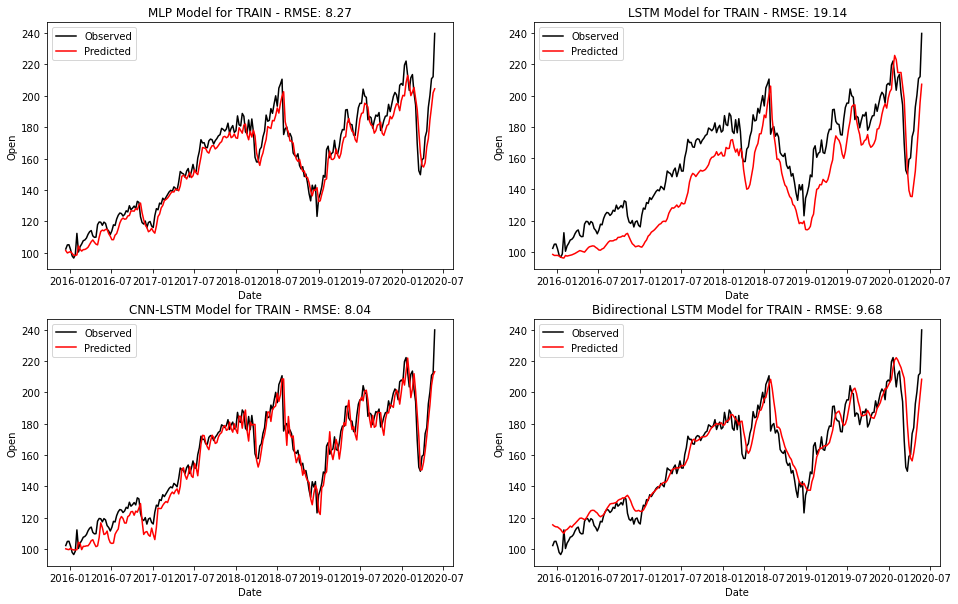

In [14]:
fig, ax = plt.subplots(2,2, figsize=(16,10))

ax[0,0].plot(train['Open'], color='black', label='Observed')
ax[0,0].plot(train_pred_mlp['Open'], color='red', label='Predicted')
ax[0,0].set_xlabel('Date')
ax[0,0].set_ylabel('Open')
ax[0,0].legend()
rms_mlp = np.round(np.sqrt(mean_squared_error(train['Open'], train_pred_mlp['Open'])), 2)
ax[0,0].set_title('MLP Model for TRAIN - RMSE: ' + str(rms_mlp))

ax[0,1].plot(train['Open'], color='black', label='Observed')
ax[0,1].plot(train_pred_lstm['Open'], color='red', label='Predicted')
ax[0,1].set_xlabel('Date')
ax[0,1].set_ylabel('Open')
ax[0,1].legend()
rms_lstm = np.round(np.sqrt(mean_squared_error(train['Open'], train_pred_lstm['Open'])), 2)
ax[0,1].set_title('LSTM Model for TRAIN - RMSE: ' + str(rms_lstm))

ax[1,0].plot(train['Open'], color='black', label='Observed')
ax[1,0].plot(train_pred_cnn_lstm['Open'], color='red', label='Predicted')
ax[1,0].set_xlabel('Date')
ax[1,0].set_ylabel('Open')
ax[1,0].legend()
rms_cnn_lstm = np.round(np.sqrt(mean_squared_error(train['Open'], train_pred_cnn_lstm['Open'])), 2)
ax[1,0].set_title('CNN-LSTM Model for TRAIN - RMSE: ' + str(rms_cnn_lstm))

ax[1,1].plot(train['Open'], color='black', label='Observed')
ax[1,1].plot(train_pred_bidirectional_lstm['Open'], color='red', label='Predicted')
ax[1,1].set_xlabel('Date')
ax[1,1].set_ylabel('Open')
ax[1,1].legend()
rms_bidirectional_lstm = np.round(np.sqrt(mean_squared_error(train['Open'], train_pred_bidirectional_lstm['Open'])), 2)
ax[1,1].set_title('Bidirectional LSTM Model for TRAIN - RMSE: ' + str(rms_bidirectional_lstm))

In [15]:
scaled_test_pred_mlp = scaled_test.copy()
y_test_pred_mlp = model_mlp.predict(X_test)
scaled_test_pred_mlp.loc[:, 'Open'] = y_test_pred_mlp

scaled_test_pred_lstm = scaled_test.copy()
y_test_pred_lstm = model_lstm.predict(X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1])))
scaled_test_pred_lstm.loc[:, 'Open'] = y_test_pred_lstm

scaled_test_pred_cnn_lstm = scaled_test.copy()
y_test_pred_cnn_lstm = model_cnn_lstm.predict(X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1])))
scaled_test_pred_cnn_lstm.loc[:, 'Open'] = y_test_pred_cnn_lstm.reshape(y_test_pred_cnn_lstm.shape[0], y_test_pred_cnn_lstm.shape[1])

scaled_test_pred_bidirectional_lstm = scaled_test.copy()
y_test_pred_bidirectional_lstm = model_bidirectional_lstm.predict(X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1])))
scaled_test_pred_bidirectional_lstm.loc[:, 'Open'] = y_test_pred_bidirectional_lstm

test_pred_mlp = scaler.inverse_transform(scaled_test_pred_mlp)
test_pred_lstm = scaler.inverse_transform(scaled_test_pred_lstm)
test_pred_cnn_lstm = scaler.inverse_transform(scaled_test_pred_cnn_lstm)
test_pred_bidirectional_lstm = scaler.inverse_transform(scaled_test_pred_bidirectional_lstm)

test_pred_mlp = pd.DataFrame(data=test_pred_mlp,
                              columns=scaled_test_pred_mlp.columns,
                              index=scaled_test_pred_mlp.index)
test_pred_lstm = pd.DataFrame(data=test_pred_lstm,
                               columns=scaled_test_pred_lstm.columns,
                               index=scaled_test_pred_lstm.index)
test_pred_cnn_lstm = pd.DataFrame(data=test_pred_cnn_lstm,
                                   columns=scaled_test_pred_cnn_lstm.columns,
                                   index=scaled_test_pred_cnn_lstm.index)
test_pred_bidirectional_lstm = pd.DataFrame(data=test_pred_bidirectional_lstm,
                                             columns=scaled_test_pred_bidirectional_lstm.columns, 
                                             index=scaled_test_pred_bidirectional_lstm.index)

Text(0.5, 1.0, 'Bidirectional LSTM Model for test - RMSE: 24.75')

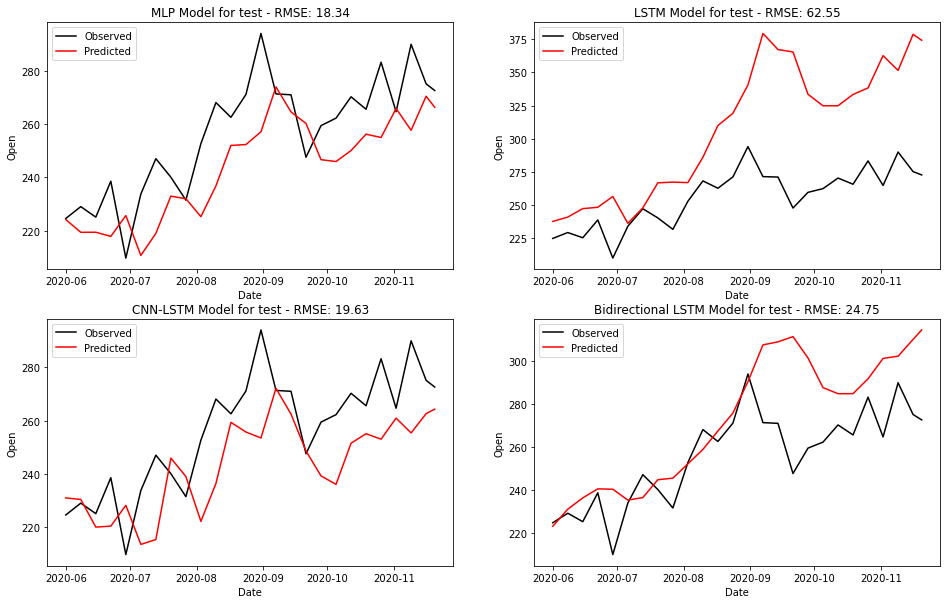

In [16]:
fig, ax = plt.subplots(2,2, figsize=(16,10))

ax[0,0].plot(test['Open'], color='black', label='Observed')
ax[0,0].plot(test_pred_mlp['Open'], color='red', label='Predicted')
ax[0,0].set_xlabel('Date')
ax[0,0].set_ylabel('Open')
ax[0,0].legend()
rms_mlp = np.round(np.sqrt(mean_squared_error(test['Open'], test_pred_mlp['Open'])), 2)
ax[0,0].set_title('MLP Model for test - RMSE: ' + str(rms_mlp))

ax[0,1].plot(test['Open'], color='black', label='Observed')
ax[0,1].plot(test_pred_lstm['Open'], color='red', label='Predicted')
ax[0,1].set_xlabel('Date')
ax[0,1].set_ylabel('Open')
ax[0,1].legend()
rms_lstm = np.round(np.sqrt(mean_squared_error(test['Open'], test_pred_lstm['Open'])), 2)
ax[0,1].set_title('LSTM Model for test - RMSE: ' + str(rms_lstm))

ax[1,0].plot(test['Open'], color='black', label='Observed')
ax[1,0].plot(test_pred_cnn_lstm['Open'], color='red', label='Predicted')
ax[1,0].set_xlabel('Date')
ax[1,0].set_ylabel('Open')
ax[1,0].legend()
rms_cnn_lstm = np.round(np.sqrt(mean_squared_error(test['Open'], test_pred_cnn_lstm['Open'])), 2)
ax[1,0].set_title('CNN-LSTM Model for test - RMSE: ' + str(rms_cnn_lstm))

ax[1,1].plot(test['Open'], color='black', label='Observed')
ax[1,1].plot(test_pred_bidirectional_lstm['Open'], color='red', label='Predicted')
ax[1,1].set_xlabel('Date')
ax[1,1].set_ylabel('Open')
ax[1,1].legend()
rms_bidirectional_lstm = np.round(np.sqrt(mean_squared_error(test['Open'], test_pred_bidirectional_lstm['Open'])), 2)
ax[1,1].set_title('Bidirectional LSTM Model for test - RMSE: ' + str(rms_bidirectional_lstm))